# Flower Image Classification | EDA
Exploratory Data Analysis

## Steps

1. [Imports](#imports)
1. [Download Dataset](#download-dataset)
1. [Preprocess Data](#preprocess-data)
1. [Split Data Set](#split-data-set)
1. [Inspect Images](#inspect-images)
1. [Class Distribution](#class-distribution)
1. [t-SNE](#t-sne)

### Dataset
[Oxford 17 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html)

# Imports

In [1]:
# python imports | 3
import os
import shutil
from pathlib import Path

# torch imports | 5
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

# torchvision imports | 4
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.models as models

# numpy | 1
import numpy as np

# matplotlib | 1
import matplotlib.pyplot as plt

# sklearn | 2
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix

# Download Dataset

In [11]:
!mkdir -p ./data
# or use !mkdir -p /content/data if google collab

In [ ]:
!curl -L -o ./data/17flowers.tgz https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz

In [16]:
!tar -xzf ./data/17flowers.tgz -C ./data/

# Organize Dataset for Data Loaders

In [60]:
def organize_by_class_labels():
    # Define class names and create mapping
    flower_categories = [
        'Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell', 'Crocus',
        'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower',
        'Daisy', 'Colts Foot', 'Dandelion', 'Cowslip', 'Buttercup',
        'Windflower', 'Pansy'
    ]

    # Create a new directory structure
    output_dir = Path('./data/flowers_labeled')
    os.makedirs(output_dir, exist_ok=True)

    # Create class directories
    for category in flower_categories:
        os.makedirs(output_dir / category, exist_ok=True)

    # Move files to appropriate directories
    jpg_dir = Path('./data/jpg')  # or wherever your .jpg files are
    for img_file in sorted(jpg_dir.glob('image_*.jpg')):
        # Get file number from filename
        file_number = int(img_file.name.split('_')[1].split('.')[0])
        # Calculate class index (0-16)
        class_idx = (file_number - 1) // 80
        # Get corresponding class name
        class_name = flower_categories[class_idx]
        # Copy file to new location
        shutil.copy2(img_file, output_dir / class_name / img_file.name)

    print("Files organized into class folders!")

In [ ]:
organize_by_class_labels()

# Preprocess Data

In [61]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Define data transformations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}

# Load the dataset
data_dir = './data/flowers_labeled'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split Data Set

In [62]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply respective transformations
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes

# Inspect Images

In [63]:
# Visualize a few images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

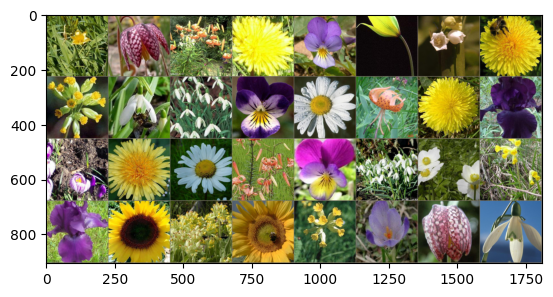

In [64]:
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
imshow(out)

# Class Distribution

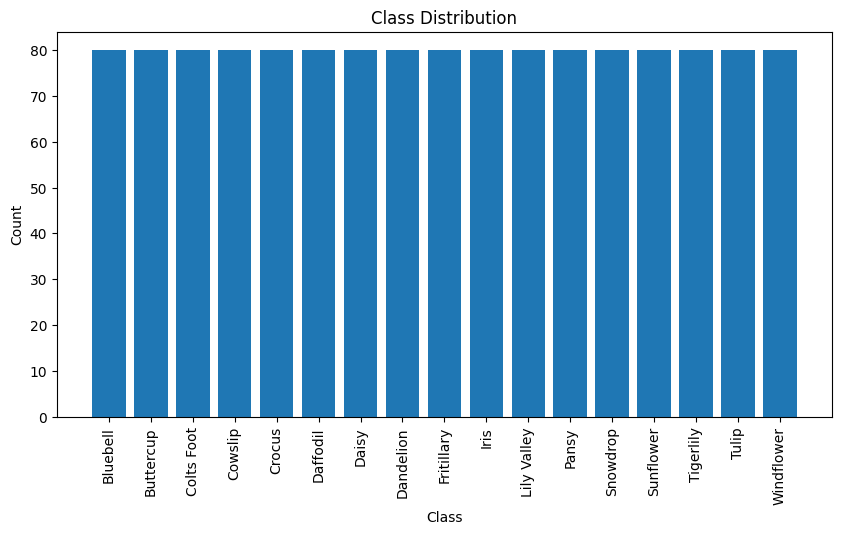

In [65]:
# Plot the distribution of the classes
class_count = {}
for _, label in dataset:
    class_name = class_names[label]
    if class_name not in class_count:
        class_count[class_name] = 0
    class_count[class_name] += 1

plt.figure(figsize=(10, 5))
plt.bar(class_count.keys(), class_count.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# t-SNE

Plot raw pixels with t-sne for comparison to t-sne with pre-trained resnet18

In [66]:
def plot_embedding(data, y, title):
    # `data` is a 2D array of shape (n_samples, 2)
    # `y` is a 1D array of shape (n_samples,), representing the labels

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        # Value of data in the first dimension
        data[:, 0],
        # Value of data in the second dimension
        data[:, 1],
        # Color of each point, representing the label
        c=y.astype(int),
        # Use a categorical color map with 20 distinct colors
        cmap="tab20",
        # size of each point
        s=60,
    )
    # Add a color bar to the right of the plot
    plt.colorbar(scatter)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.show()

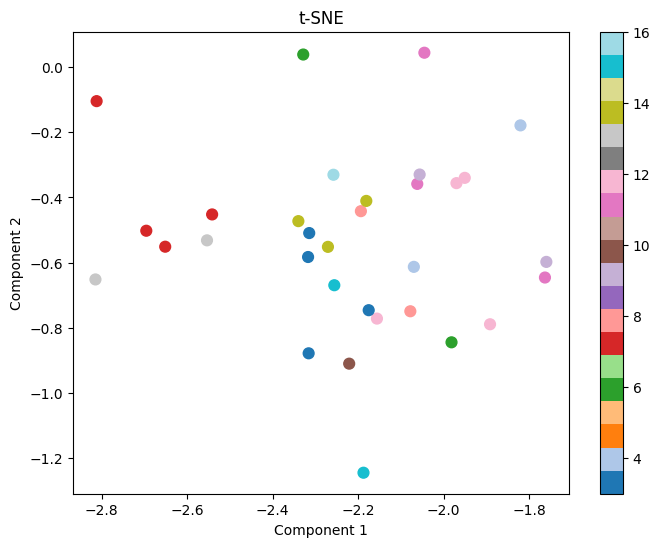

In [67]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(inputs.view(inputs.size(0), -1).numpy())

plot_embedding(x_tsne, classes.numpy(), "t-SNE")

Plot with pre-trained resnet18

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


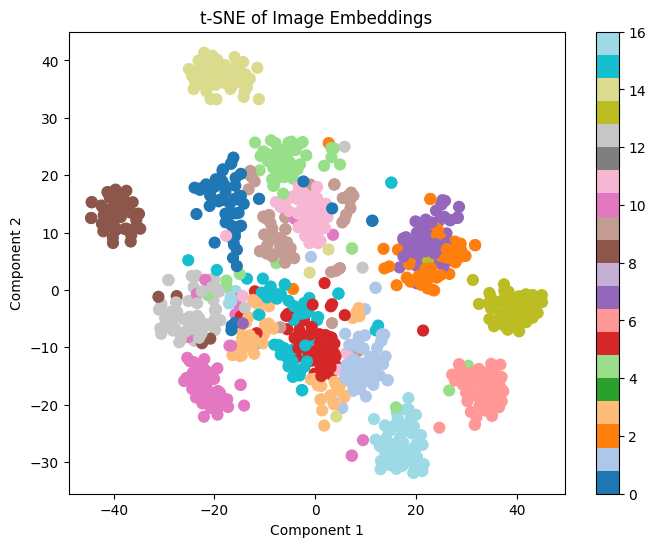

In [68]:
# Load a pre-trained model
model = models.resnet18(pretrained=True)

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-1])

# Set the model to evaluation mode
model.eval()

# Move the model to the appropriate device
model = model.to(device)

# Function to get embeddings
def get_embeddings(dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)
            embeddings.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Get embeddings for the train dataset
train_embeddings, train_labels = get_embeddings(dataloaders['train'])

# Perform t-SNE on the embeddings
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(train_embeddings)

# Plot the t-SNE embeddings
plot_embedding(x_tsne, train_labels, "t-SNE of Image Embeddings")

Prep and check classification task eval metrics with pre-trained model before fine tuning

In [69]:
# Modify the ResNet18 model
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    # nn.Linear(num_ftrs, 512),
    # nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, len(class_names)),
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# Evaluate the model on the test set
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Bluebell       0.00      0.00      0.00         8
   Buttercup       0.23      0.42      0.29        12
  Colts Foot       0.00      0.00      0.00        12
     Cowslip       0.00      0.00      0.00        13
      Crocus       0.07      0.33      0.12         9
    Daffodil       0.00      0.00      0.00         8
       Daisy       0.00      0.00      0.00         7
   Dandelion       0.12      0.60      0.20        10
  Fritillary       0.00      0.00      0.00         9
        Iris       0.00      0.00      0.00         7
 Lily Valley       0.00      0.00      0.00         3
       Pansy       0.00      0.00      0.00        10
    Snowdrop       0.00      0.00      0.00         5
   Sunflower       0.00      0.00      0.00         5
   Tigerlily       0.00      0.00      0.00         6
       Tulip       0.00      0.00      0.00         9
  Windflower       0.00      0.00      0.00         4

    accuracy              

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set 

Plot confusion matrics on classification task before fine tuning

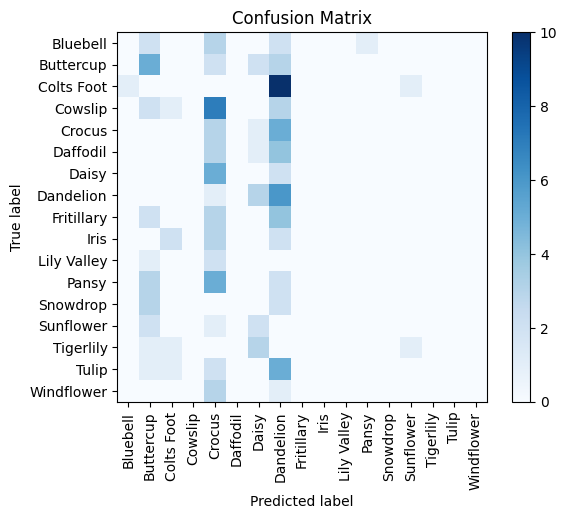

In [71]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()